# **AIFA Assignment 1**

**Team Members:**

Anamika Kumari (20AE3AI01)

Kartik Narayan Sahu (20AE3AI04)

Niharika Singh (20MI3AI17)

In [1]:
# Import necessary libraries

import random
import heapq
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
import cv2

In [2]:
# Define grid dimensions and initial configuration
grid_rows, grid_cols = 6, 17
num_agents = 3

initial_pos = [(0, 0), (9, 5), (7, 1)]

pickup_pos = [(0, 5), (6, 4), (12, 1)]

goal_pos = [(12, 3), (10, 0), (5, 0)]

delivery_pos = [(8, 0), (5, 5), (15, 3)]

obstacles = [(13, 0), (1, 2), (15, 2), (10, 4), (3, 5)]
print(f'Input:\n')
print(f'Initial Positions: {initial_pos}\nGoal Positions: {goal_pos}\nPickup Positions: {pickup_pos}\nDelivery Positions: {delivery_pos}\nObstacles: {obstacles}')

Input:

Initial Positions: [(0, 0), (9, 5), (7, 1)]
Goal Positions: [(12, 3), (10, 0), (5, 0)]
Pickup Positions: [(0, 5), (6, 4), (12, 1)]
Delivery Positions: [(8, 0), (5, 5), (15, 3)]
Obstacles: [(13, 0), (1, 2), (15, 2), (10, 4), (3, 5)]


In [3]:
class Node:
    def __init__(self, state, parent=None, cost=0, cost_heuristic=0, time = 0):
        self.state = state  # Current state
        self.parent = parent  # Parent node
        self.cost = cost  # g(n): Cost from the start node to current node
        self.heuristic = cost_heuristic  # h(n): Heuristic cost from current node to the goal

    def __lt__(self, other):
        # selecting the node with minimum f(n) value
        # f(n) = g(n) + h(n)
        return (self.cost + self.heuristic) < (other.cost + other.heuristic)

In [4]:
#####################################......Constraints......#####################################

def is_valid_location(state):
    x, y = state
    return 0 <= y < grid_rows and 0 <= x < grid_cols

In [5]:
#####################################......Constraints......#####################################

def is_location_constrained(agent, state, timestep, constraints):
    return any((a, s, t) == (agent, state, timestep) for (a, s, t) in constraints)

In [6]:
#####################################......Constraints......#####################################

def is_obstacle(state):
    return state in obstacles

In [7]:
def evaluate_cost_heuristic(state, goal):
    return abs(state[0] - goal[0]) + abs(state[1] - goal[1])      # calculation of Cost_heuristics (i.e, manhattan distance between two cells)

In [8]:
# Get valid neighbours

def get_valid_neighbors(agent, state, timestep, constraints):
    neighbors = []
    x, y = state
    for dx, dy in [(1, 0), (-1, 0), (0, 1), (0, -1)]:
        new_x, new_y = x + dx, y + dy
        if is_valid_location((new_x, new_y)) and not is_obstacle((new_x, new_y)) and not is_location_constrained(agent, (new_x, new_y), timestep + 1, constraints):
            neighbors.append((new_x, new_y))
    return neighbors

In [9]:
# Search for the path

def search(initial, goal, agent, constraints):
  OPEN = []

  start_node  = Node(state = initial, cost = 0, cost_heuristic = evaluate_cost_heuristic(initial, goal))
  heapq.heappush(OPEN, (start_node, 0))

  while OPEN:
    current_node, current_timestep = heapq.heappop(OPEN)
    if current_node.state == goal:
      path = []
      while current_node:
        path.append(current_node.state)
        current_node = current_node.parent
      return path[::-1]

    for neighbor_state in get_valid_neighbors(agent, current_node.state, current_timestep, constraints):
      tentative_cost = current_node.cost + 1

      neighbor_node = Node(state=neighbor_state, parent=current_node, cost=tentative_cost,
                           cost_heuristic=evaluate_cost_heuristic(neighbor_state, goal))
      if neighbor_node not in OPEN:
        heapq.heappush(OPEN, (neighbor_node, current_timestep + 1))

  return None


In [10]:
# Validation of the path

def validate_paths(node):
    max_length = max(len(path) for path in node.solution)  # Find the maximum pathlength
    conflicts = []
    for i in range(max_length):
        for j in range(num_agents):
            if i < len(node.solution[j]):
                for l in range(j + 1, num_agents):
                    if i < len(node.solution[l]) and node.solution[j][i] == node.solution[l][i]:
                        conflicts = [j, l, node.solution[j][i], i]
                        return conflicts

    return None

In [11]:
def find_paths(initial_pos, final_pos, constraints):
  paths = []
  for agent, (initial,goal) in enumerate(zip(initial_pos, final_pos)):
    sub_path = search(initial, goal, agent, constraints)
    paths.append(sub_path)
  return paths

In [12]:
# Calculate overall Cost

def SIC(path):
  cost = 0
  for p in path:
    cost+=len(p)
  return cost

In [13]:
class State:
  def __init__(self):
    self.constraints = []
    self.solution = []
    self.cost = 0

# Conflict Based Search

In [14]:
def cbs_algo(initial_pos, final_pos):
  root = State()
  root.constraints = []
  root.solution = find_paths(initial_pos, final_pos, root.constraints)
  root.cost = SIC(root.solution)

  OPEN = [root]

  while(OPEN):
      P = min(OPEN, key=lambda n: n.cost)
      OPEN.remove(P)

      conflicts = validate_paths(P)
      if (conflicts == None):
        return P.solution

      C = conflicts[0:2]

      for agent in C:
        state = conflicts[2]
        time = conflicts[3]
        A = State()
        A.constraints.extend(P.constraints)
        A.constraints.append((agent, state, time))

        A.solution = find_paths(initial_pos, final_pos, A.constraints)
        A.cost = SIC(A.solution)

        if(A.cost < float('inf')):
          OPEN.append(A)

  return None


In [15]:
initial_2_pickup = cbs_algo(initial_pos, pickup_pos)
pickup_2_delivery = cbs_algo(pickup_pos, delivery_pos)
delivery_2_goal = cbs_algo(delivery_pos, goal_pos)

In [16]:
time1 = max(len(initial_2_pickup[i]) for i in range(num_agents))
time2 = max(len(pickup_2_delivery[i]) for i in range(num_agents))
time3 = max(len(delivery_2_goal[i]) for i in range(num_agents))

In [17]:
agent1_path = initial_2_pickup[0][:-1] + [(initial_2_pickup[0][-1]) for i in range(len(initial_2_pickup[0]), time1)] + pickup_2_delivery[0][:-1] +\
 [(pickup_2_delivery[0][-1]) for i in range(len(pickup_2_delivery[0]), time2)] + delivery_2_goal[0][:] + \
  [(delivery_2_goal[0][-1]) for i in range(len(delivery_2_goal[0]), time3)]

agent2_path = initial_2_pickup[1][:-1] + [(initial_2_pickup[1][-1]) for i in range(len(initial_2_pickup[1]), time1)] + pickup_2_delivery[1][:-1] +\
 [(pickup_2_delivery[1][-1]) for i in range(len(pickup_2_delivery[1]), time2)] + delivery_2_goal[1][:] + \
  [(delivery_2_goal[1][-1]) for i in range(len(delivery_2_goal[1]), time3)]

agent3_path = initial_2_pickup[2][:-1] + [(initial_2_pickup[2][-1]) for i in range(len(initial_2_pickup[2]), time1)] + pickup_2_delivery[2][:-1] +\
 [(pickup_2_delivery[2][-1]) for i in range(len(pickup_2_delivery[2]), time2)] + delivery_2_goal[2][:] + \
  [(delivery_2_goal[2][-1]) for i in range(len(delivery_2_goal[2]), time3)]


In [18]:
print(f'Overall Time Completion: {len(agent3_path)}')

Overall Time Completion: 32


In [19]:
pip install prettytable

Note: you may need to restart the kernel to use updated packages.


In [20]:
from prettytable import PrettyTable

# Specify the Column Names while initializing the Table
myTable = PrettyTable(["Timestep", "Agent1", "Agent2", "Agent3"])

In [21]:
for i in range(len(agent1_path)):
  myTable.add_row([i, agent1_path[i], agent2_path[i], agent3_path[i]])

In [22]:
print(f'Overall Time Completion: {len(agent3_path)}')
print(myTable)

Overall Time Completion: 32
+----------+---------+---------+---------+
| Timestep |  Agent1 |  Agent2 |  Agent3 |
+----------+---------+---------+---------+
|    0     |  (0, 0) |  (9, 5) |  (7, 1) |
|    1     |  (0, 1) |  (8, 5) |  (8, 1) |
|    2     |  (0, 2) |  (7, 5) |  (9, 1) |
|    3     |  (0, 3) |  (6, 5) | (10, 1) |
|    4     |  (0, 4) |  (6, 4) | (11, 1) |
|    5     |  (0, 5) |  (6, 4) | (12, 1) |
|    6     |  (1, 5) |  (5, 4) | (12, 2) |
|    7     |  (1, 4) |  (5, 5) | (13, 2) |
|    8     |  (2, 4) |  (5, 5) | (13, 3) |
|    9     |  (3, 4) |  (5, 5) | (14, 3) |
|    10    |  (3, 3) |  (5, 5) | (15, 3) |
|    11    |  (3, 2) |  (5, 5) | (15, 3) |
|    12    |  (3, 1) |  (5, 5) | (15, 3) |
|    13    |  (4, 1) |  (5, 5) | (15, 3) |
|    14    |  (5, 1) |  (5, 5) | (15, 3) |
|    15    |  (5, 0) |  (5, 5) | (15, 3) |
|    16    |  (6, 0) |  (5, 5) | (15, 3) |
|    17    |  (7, 0) |  (5, 5) | (15, 3) |
|    18    |  (8, 0) |  (5, 5) | (15, 3) |
|    19    |  (9, 0) |  (6

## **Visualiser**


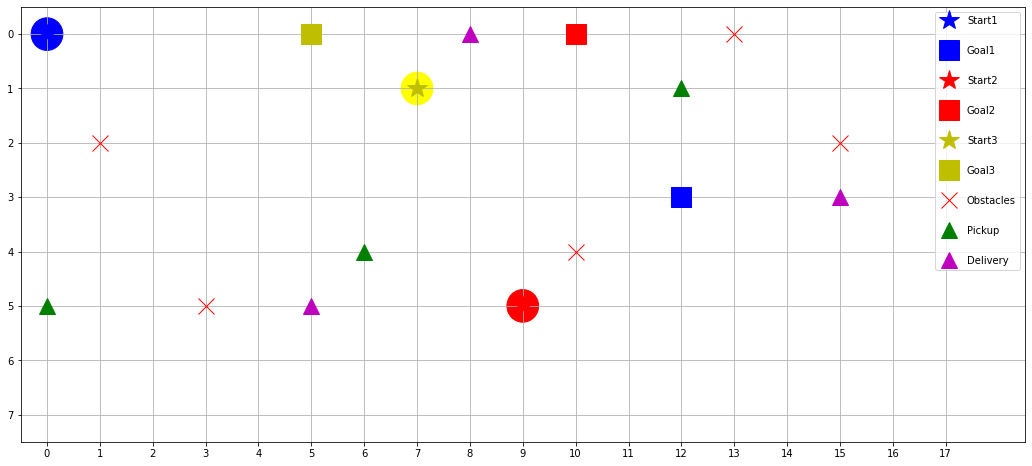

In [24]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

# Define the figure and axis
fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(18)
ax.set_xlim(-0.5, 18.5)
ax.set_ylim(-0.5, 7.5)
x_ticks = np.arange(0, 18, 1)
ax.set_xticks(x_ticks)
y_ticks = np.arange(0, 18, 1)
ax.set_xticks(y_ticks)
ax.grid(which='both')

# Create a circular agent
agent_radius = 0.3
agent1 = plt.Circle((2, 2), agent_radius, fill=True, color='blue')
agent2 = plt.Circle((2, 2), agent_radius, fill=True, color='red')
agent3 = plt.Circle((2, 2), agent_radius, fill=True, color='yellow')

ax.add_patch(agent1)
ax.add_patch(agent2)
ax.add_patch(agent3)

# Set the start and goal positions
start1 = agent1_path[0]
goal1 = agent1_path[-1]
start2 = agent2_path[0]
goal2 = agent2_path[-1]
start3 = agent3_path[0]
goal3 = agent3_path[-1]

path1 = agent1_path
path2 = agent2_path
path3 = agent3_path

# Function to update the agent's position in the animation
def update(frame):
    agent1.center = path1[frame]
    agent2.center = path2[frame]
    agent3.center = path3[frame]
    return agent1, agent2, agent3

# Create an animation
ani = animation.FuncAnimation(fig, update, frames= len(path1), repeat=False, blit=True)
# Show the animation

plt.plot(start1[0], start1[1], 'b*', markersize=20, label='Start1')
plt.plot(goal1[0], goal1[1], 'bs', markersize=20, label='Goal1')
plt.plot(start2[0], start2[1], 'r*', markersize=20, label='Start2')
plt.plot(goal2[0], goal2[1], 'rs', markersize=20, label='Goal2')
plt.plot(start3[0], start3[1], 'y*', markersize=20, label='Start3')
plt.plot(goal3[0], goal3[1], 'ys', markersize=20, label='Goal3')

plt.plot([obstacles[i][0] for i in range(len(obstacles))], [obstacles[i][1] for i in range(len(obstacles))], 'rx', markersize=16, label='Obstacles')
plt.plot([pickup_pos[i][0] for i in range(len(pickup_pos))], [pickup_pos[i][1] for i in range(len(pickup_pos))], 'g^', markersize=16, label='Pickup')
plt.plot([delivery_pos[i][0] for i in range(len(delivery_pos))], [delivery_pos[i][1] for i in range(len(delivery_pos))], 'm^', markersize=16, label='Delivery')
plt.legend(labelspacing = 2)
plt.gca().invert_yaxis()
#plt.grid()
plt.show()
ani.save("anim.mp4")